In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
# import os
# import shutil
# from pathlib import Path

# # Define paths
# source_dirs = [
#     './Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-I/MedicalExpert-I',
#     './Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-II/MedicalExpert-II'
# ]
# target_root = './merged_dataset'

# # Create target root directory if it doesn't exist
# os.makedirs(target_root, exist_ok=True)

# # Merge subfolders
# for source_dir in source_dirs:
#     for class_name in os.listdir(source_dir):
#         class_src_path = os.path.join(source_dir, class_name)
#         class_dst_path = os.path.join(target_root, class_name)

#         if os.path.isdir(class_src_path):
#             os.makedirs(class_dst_path, exist_ok=True)
#             for filename in os.listdir(class_src_path):
#                 src_file = os.path.join(class_src_path, filename)
#                 dst_file = os.path.join(class_dst_path, f"{Path(source_dir).name}_{filename}")
#                 shutil.copy2(src_file, dst_file)

# print("Merge complete.")

Merge complete.


In [3]:
!ls ./merged_dataset

0Normal   1Doubtful 2Mild     3Moderate 4Severe


In [4]:
import keras
import tensorflow as tf
import numpy as np
import PIL
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/Users/captain-mac/Documents/Code/kaggle/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    target_root,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(162, 300),
    seed=42,
    validation_split=0.2, 
    subset='training',
)

val_ds = keras.utils.image_dataset_from_directory(
    target_root,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(162, 300),
    seed=42,
    validation_split=0.2, 
    subset='validation',
)

train_ds, val_ds

Found 3300 files belonging to 5 classes.
Using 2640 files for training.
Found 3300 files belonging to 5 classes.
Using 660 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 162, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 162, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [6]:
train_ds.class_names

['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']

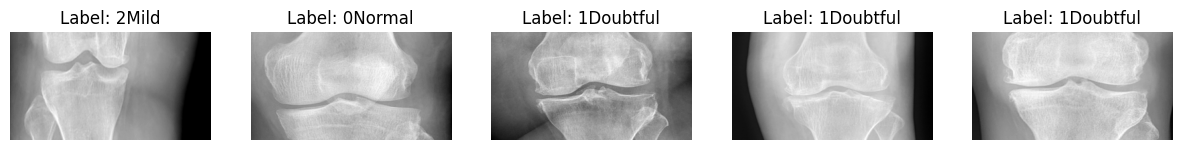

In [7]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # For grayscale
        plt.title(f"Label: {train_ds.class_names[np.argmax(labels[i].numpy())]}")
        plt.axis("off")
    plt.show()

In [8]:
# First, analyze your class distribution
for ds_name, ds in [("Training", train_ds), ("Validation", val_ds)]:
    class_counts = {}
    for _, labels in ds:
        for i in range(len(ds.class_names)):
            class_counts[ds.class_names[i]] = class_counts.get(
                ds.class_names[i], 0
            ) + np.sum(labels[:, i])

    print(f"{ds_name} class distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {int(count)} images")


# plotting the class distribution
def plot_class_distribution(ds, title):
    class_counts = {cls: 0 for cls in ds.class_names}
    for _, labels in ds:
        for i in range(len(ds.class_names)):
            class_counts[ds.class_names[i]] += np.sum(labels[:, i])

    fig = go.Figure(
        data=[
            go.Bar(
                x=list(class_counts.keys()),
                y=list(class_counts.values()),
                text=np.round(
                    (list(class_counts.values()) / np.sum(list(class_counts.values()))) * 100,
                    2,
                ),
            )
        ]
    )
    fig.update_layout(
        title=title, xaxis_title="Classes", yaxis_title="Number of Images"
    )
    fig.show()


plot_class_distribution(train_ds, "Training Set Class Distribution")
plot_class_distribution(val_ds, "Validation Set Class Distribution")

Training class distribution:
  0Normal: 822 images
  1Doubtful: 766 images
  2Mild: 383 images
  3Moderate: 350 images
  4Severe: 319 images
Validation class distribution:
  0Normal: 195 images
  1Doubtful: 199 images
  2Mild: 81 images
  3Moderate: 92 images
  4Severe: 93 images


In [9]:
# adding class weights
from sklearn.utils.class_weight import compute_class_weight

# Get training labels
train_labels = []
for _, labels_batch in train_ds:
    train_labels.extend(np.argmax(labels_batch, axis=1))

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.6423357664233577), 1: np.float64(0.6892950391644909), 2: np.float64(1.3785900783289817), 3: np.float64(1.5085714285714287), 4: np.float64(1.6551724137931034)}


In [ ]:
img_height = 162
img_width = 300
num_classes = len(train_ds.class_names)

# base model for transfer learning
base_model = keras.applications.DenseNet121(
    input_shape=(img_height, img_width, 3),
    include_top=False,
)
base_model.trainable = False  # Freeze the base model

model = keras.models.Sequential(
    [
        keras.layers.Input((img_height, img_width, 1)),
        keras.layers.Lambda(
            lambda x: tf.repeat(
                x,
                3,
                axis=3,
            )
        ),  # Convert grayscale to RGB
        keras.layers.Lambda(keras.applications.densenet.preprocess_input),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalFocalCrossentropy(),
    metrics=[
        keras.metrics.F1Score(average="weighted"),
        keras.metrics.AUC(multi_label=True),
    ],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 162, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 162, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 5, 9, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,285 (27.87 MB)

 Trainable params: 265,733 (1.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="f1_score",
            patience=10,
            restore_best_weights=True,
            mode="max",
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_f1_score",
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1,
            mode="max",
        ),
        keras.callbacks.ModelCheckpoint(
            "best_model.keras",
            monitor="val_f1_score",
            save_best_only=True,
            mode="max",
            verbose=1,
        ),
    ],
)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - auc: 0.7615 - f1_score: 0.4697 - loss: 0.2384
Epoch 1: val_f1_score improved from -inf to 0.64083, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 633ms/step - auc: 0.7625 - f1_score: 0.4709 - loss: 0.2377 - val_auc: 0.9031 - val_f1_score: 0.6408 - val_loss: 0.1187 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - auc: 0.9376 - f1_score: 0.7358 - loss: 0.0780
Epoch 2: val_f1_score improved from 0.64083 to 0.77151, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 625ms/step - auc: 0.9376 - f1_score: 0.7360 - loss: 0.0779 - val_auc: 0.9492 - val_f1_score: 0.7715 - val_loss: 0.0717 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - auc: 0.9708 - f1_score: 0.8370 - loss: 0.0429
Epoch 3: val_f1_score improved from 0.77151 to 0.83718, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 627ms/step - auc: 0.9708 - f1_score: 0.8372 - loss: 0.

KeyboardInterrupt: 

In [12]:
import pandas as pd

# Convert tensor values to floats
clean_history = {}
for key, values in history.history.items():
    clean_history[key] = [
        v.numpy() if isinstance(v, tf.Tensor) else v
        for v in values
    ]

# Create a cleaned DataFrame
history_df = pd.DataFrame(clean_history)
history_df.head()

NameError: name 'history' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for metric in [
    'loss',
    'f1_score',
    'auc',
]:
    plt.plot(history_df[metric], label=f'Training {metric}', marker='o')
    plt.plot(history_df[f'val_{metric}'], label=f'Validation {metric}', marker='o')

plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
!ls ./knee-osteoarthritis-dataset-with-severity-test

0 1 2 3 4


In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    './knee-osteoarthritis-dataset-with-severity-test',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(162, 300),
    shuffle=False
)

Found 1526 files belonging to 5 classes.


In [16]:
results = model.evaluate(test_ds)
print("Test Loss (CategoricalFocalEntropy):", results[0])
print("F1 Score:", results[1])
print("AUC:", results[2])

48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 499ms/step - auc: 0.2136 - f1_score: 0.4166 - loss: 0.6778
Test Loss (CategoricalFocalEntropy): 0.9007891416549683
F1 Score: 0.2188677340745926
AUC: 0.6021432876586914


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# computing the class weights
test_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(true_labels, axis=1)),
    y=np.argmax(true_labels, axis=1)
)
test_class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Test Class Weights:", test_class_weights_dict)

# weighted classification report
print("Classification Report:")
classification_report(
    np.argmax(true_labels, axis=1),
    predicted_labels,
    target_names=test_ds.class_names,
    output_dict=False
)

48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 571ms/step
Test Class Weights: {0: np.float64(0.6423357664233577), 1: np.float64(0.6892950391644909), 2: np.float64(1.3785900783289817), 3: np.float64(1.5085714285714287), 4: np.float64(1.6551724137931034)}
Classification Report:


'              precision    recall  f1-score   support\n\n           0       0.55      0.41      0.47       604\n           1       0.16      0.07      0.09       275\n           2       0.17      0.02      0.04       403\n           3       0.31      0.02      0.04       200\n           4       0.04      0.89      0.08        44\n\n    accuracy                           0.21      1526\n   macro avg       0.25      0.28      0.14      1526\nweighted avg       0.33      0.21      0.22      1526\n'

0   1   2  3    4
0  247  47  30  3  277
1   94  18   6  1  156
2   71  28   8  5  291
3   38  13   3  4  142
4    1   4   0  0   39

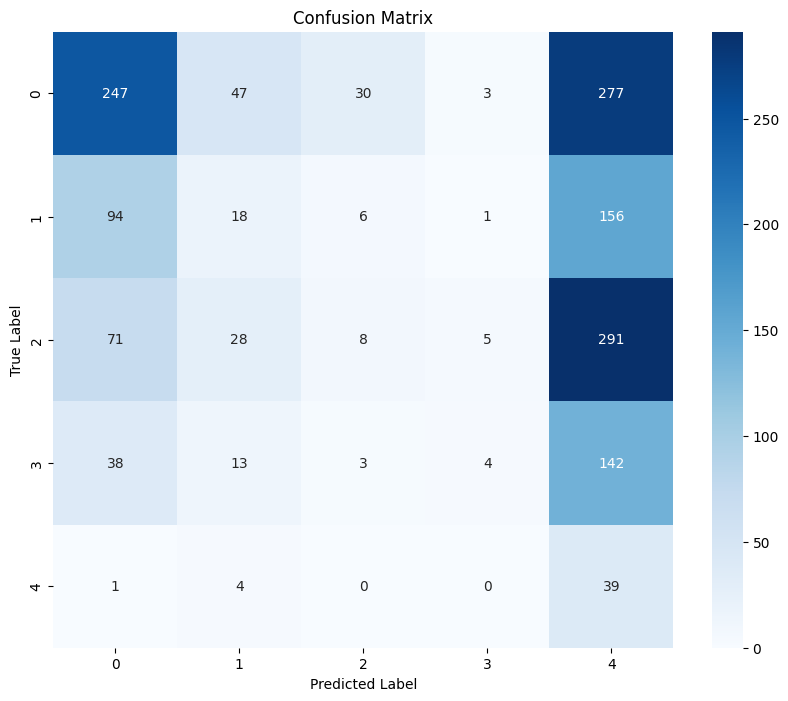

In [21]:
confusion_mtx = confusion_matrix(
    np.argmax(true_labels, axis=1),
    predicted_labels
)
display(pd.DataFrame(
    confusion_mtx,
    index=test_ds.class_names,
    columns=test_ds.class_names
))
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=test_ds.class_names,
    yticklabels=test_ds.class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label') 
plt.title('Confusion Matrix')
plt.show()